In [20]:
# =========================
# STEP 1: IMPORT LIBRARIES
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
import os
from sklearn.preprocessing import LabelEncoder

# Custom MultiColumnLabelEncoder
class MultiColumnLabelEncoder:
    def __init__(self, columns=None):
        self.columns = columns
        self.encoders = {}

    def fit(self, x):
        for col in self.columns:
            le = LabelEncoder()
            le.fit(x[col])
            self.encoders[col] = le
        return self

    def transform(self, x):
        output = x.copy()
        for col in self.columns:
            output[col] = self.encoders[col].transform(output[col])
        return output

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)




In [21]:
# =========================
# STEP 2: READ THE DATASET
# =========================
df = pd.read_csv("Dataset/garments_worker_productivity.csv")
print("First 5 rows:\n", df.head())
print("\nDataset Info:\n")
print(df.info())



First 5 rows:
        date   quarter  department       day  team  targeted_productivity  \
0  1/1/2015  Quarter1      sweing  Thursday     8                   0.80   
1  1/1/2015  Quarter1  finishing   Thursday     1                   0.75   
2  1/1/2015  Quarter1      sweing  Thursday    11                   0.80   
3  1/1/2015  Quarter1      sweing  Thursday    12                   0.80   
4  1/1/2015  Quarter1      sweing  Thursday     6                   0.80   

     smv     wip  over_time  incentive  idle_time  idle_men  \
0  26.16  1108.0       7080         98        0.0         0   
1   3.94     NaN        960          0        0.0         0   
2  11.41   968.0       3660         50        0.0         0   
3  11.41   968.0       3660         50        0.0         0   
4  25.90  1170.0       1920         50        0.0         0   

   no_of_style_change  no_of_workers  actual_productivity  
0                   0           59.0             0.940725  
1                   0        

Descriptive Statistics:
               team  targeted_productivity          smv           wip  \
count  1197.000000            1197.000000  1197.000000    691.000000   
mean      6.426901               0.729632    15.062172   1190.465991   
std       3.463963               0.097891    10.943219   1837.455001   
min       1.000000               0.070000     2.900000      7.000000   
25%       3.000000               0.700000     3.940000    774.500000   
50%       6.000000               0.750000    15.260000   1039.000000   
75%       9.000000               0.800000    24.260000   1252.500000   
max      12.000000               0.800000    54.560000  23122.000000   

          over_time    incentive    idle_time     idle_men  \
count   1197.000000  1197.000000  1197.000000  1197.000000   
mean    4567.460317    38.210526     0.730159     0.369256   
std     3348.823563   160.182643    12.709757     3.268987   
min        0.000000     0.000000     0.000000     0.000000   
25%     1440.000

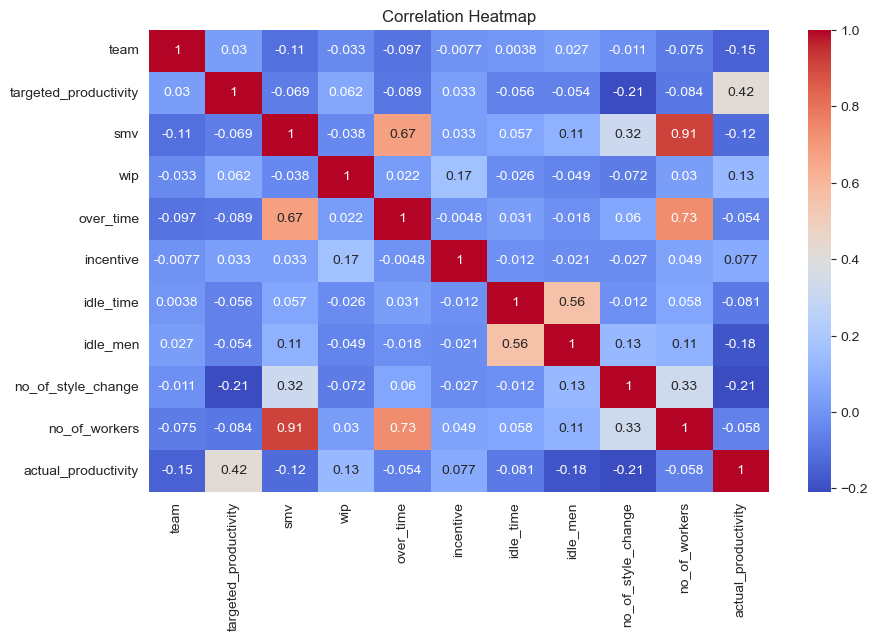

In [22]:
# =========================
# STEP 3: DESCRIPTIVE & CORRELATION ANALYSIS
# =========================
print("Descriptive Statistics:\n", df.describe())

# Correlation only for numeric columns
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [23]:
# =========================
# =========================
# STEP 4: CHECK & HANDLE NULL VALUES
# =========================
print("Null values before handling:\n", df.isnull().sum())
df.fillna(df.mean(numeric_only=True), inplace=True)
print("Null values after handling:\n", df.isnull().sum())



Null values before handling:
 date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64
Null values after handling:
 date                     0
quarter                  0
department               0
day                      0
team                     0
targeted_productivity    0
smv                      0
wip                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
no_of_workers            0
actual_productivity      0
dtype: int64


In [24]:
# STEP 5: HANDLE DATE & DEPARTMENT
# =================================
df.columns = df.columns.str.strip().str.lower()

if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['month'] = df['date'].dt.month          # keep numeric
    df['day'] = df['date'].dt.day_name()       # convert to day name for categorical encoding
    df.drop(columns=['date'], inplace=True)
    print("Date column processed: month (numeric) & day (categorical) extracted.")
else:
    print("No 'date' column found — skipping date processing.")

if 'department' in df.columns:
    df['department'] = df['department'].replace({'sweing': 'sewing'})




Date column processed: month (numeric) & day (categorical) extracted.


In [25]:
# STEP 6: FILTER REQUIRED 14 FEATURES
# ===================================
required_features = [
    'quarter', 'day', 'targeted_productivity', 'over_time', 'idle_time',
    'no_of_style_change', 'month', 'department', 'team', 'smv',
    'incentive', 'idle_men', 'no_of_workers', 'actual_productivity'
]

missing_features = [col for col in required_features if col not in df.columns]
if missing_features:
    raise ValueError(f"Missing required features in dataset: {missing_features}")

df = df[required_features]
print("Dataset filtered to required features:\n", df.head())

Dataset filtered to required features:
     quarter       day  targeted_productivity  over_time  idle_time  \
0  Quarter1  Thursday                   0.80       7080        0.0   
1  Quarter1  Thursday                   0.75        960        0.0   
2  Quarter1  Thursday                   0.80       3660        0.0   
3  Quarter1  Thursday                   0.80       3660        0.0   
4  Quarter1  Thursday                   0.80       1920        0.0   

   no_of_style_change  month  department  team    smv  incentive  idle_men  \
0                   0      1      sewing     8  26.16         98         0   
1                   0      1  finishing      1   3.94          0         0   
2                   0      1      sewing    11  11.41         50         0   
3                   0      1      sewing    12  11.41         50         0   
4                   0      1      sewing     6  25.90         50         0   

   no_of_workers  actual_productivity  
0           59.0             0

In [26]:
# STEP 7: HANDLE CATEGORICAL VALUES (quarter, department, day)
# ============================================================
categorical_cols = ['quarter', 'department', 'day']

print("Categorical columns explicitly set:", categorical_cols)

mle = MultiColumnLabelEncoder(columns=categorical_cols)
df = mle.fit_transform(df)

print("Dataset after encoding:\n", df.head())




Categorical columns explicitly set: ['quarter', 'department', 'day']
Dataset after encoding:
    quarter  day  targeted_productivity  over_time  idle_time  \
0        0    3                   0.80       7080        0.0   
1        0    3                   0.75        960        0.0   
2        0    3                   0.80       3660        0.0   
3        0    3                   0.80       3660        0.0   
4        0    3                   0.80       1920        0.0   

   no_of_style_change  month  department  team    smv  incentive  idle_men  \
0                   0      1           2     8  26.16         98         0   
1                   0      1           1     1   3.94          0         0   
2                   0      1           2    11  11.41         50         0   
3                   0      1           2    12  11.41         50         0   
4                   0      1           2     6  25.90         50         0   

   no_of_workers  actual_productivity  
0           

In [27]:
# =========================
# STEP 7: SPLIT DATA
# =========================
X = df.drop(columns=['actual_productivity'])
y = df['actual_productivity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (957, 13)
Test set shape: (240, 13)


In [28]:
# =========================
# STEP 8: TRAIN MODELS
# =========================
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)



In [29]:
# =========================
# STEP 9: EVALUATE PERFORMANCE
# =========================
def evaluate(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} -> MSE: {mse:.4f}, R2: {r2:.4f}")
    return r2

lr_score = evaluate(y_test, lr_pred, "Linear Regression")
rf_score = evaluate(y_test, rf_pred, "Random Forest")
xgb_score = evaluate(y_test, xgb_pred, "XGBoost")

if rf_score > max(lr_score, xgb_score):
    best_model = rf
elif xgb_score > lr_score:
    best_model = xgb
else:
    best_model = lr

print("\nBest Model Selected:", type(best_model).__name__)



Linear Regression -> MSE: 0.0216, R2: 0.1862
Random Forest -> MSE: 0.0118, R2: 0.5549
XGBoost -> MSE: 0.0153, R2: 0.4239

Best Model Selected: RandomForestRegressor


In [30]:
# =========================
# STEP 10: SAVE MODELS & ENCODERS
# =========================
os.makedirs("Training files", exist_ok=True)
os.makedirs("IBM Files", exist_ok=True)
os.makedirs("Flask", exist_ok=True)

with open("Flask/multi_column_label_encoder.pkl", "wb") as f:
    pickle.dump(mle, f)

with open("Training files/mcde.pkl", "wb") as f:
    pickle.dump(rf, f)

xgb.save_model("IBM Files/xgb_gwp.json")

with open("Flask/gwp.pkl", "wb") as f:
    pickle.dump(best_model, f)
with open("IBM Files/gwp.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Models & encoder saved successfully.")



Models & encoder saved successfully.
